<a href="https://colab.research.google.com/github/kenneth-craig/academyPub/blob/main/ARIMA-Monthly-Champagne-Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install latest statsmodel library v0.13
!pip install -U statsmodels

     |████████████████████████████████| 9.8 MB 13.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
# Easiest Way to get file uploaded to Google Colab environment
from google.colab import files
file = files.upload()

Saving champagne.csv to champagne.csv


# End To End ARIMA Sample Using Boston Armed Robery Dataset - Ch30
**Problem Description** - Ch 32.2

**Test Harness** - Ch 32.3

**Persistence Model for Comparison Purposes** - Ch 32.4

**Data Analysis** - Ch 32.5

**ARIMA Model** - Ch 32.6

**Model Validation** - Ch 31.7

# Problem Description
- Predict the number of monthly sales of champagne for the Perrin Freres label
- Provides the number of monthly sales of champagne from January 1964 to September 1972, or just under 10 years of data
- Units: The values are a count of millions of sales
- There are 105 observation, the final year of data will be used for validation (oot)
- The problem will use Rolling Forecast type model

# Test Harness
**Evaluation Method**
- Evaluate the performance of predictions using Root Mean Squared (RMSE) - This will give more weight to predictions that are grossly wrong and will have same unit as original data
- Any transformations to the data (e.g. box-cox) must be reversed before RMSE is calculated and calculated & reported to make the performance between different mothods directly comparable
- The dataset is not current therefore the final 12 months of data will be withheld to validate for the final model.
- Will use walk-forward validation will be used for model evaluation i.e. one-step forecasts are needed given all the available data

**Test Strategy**
- Walk forward validation will work as follows:
 - 50% of data will be held back for training the model
 - Remaining 50% of the dataset will be iterated and used to test the model
- For each step in the Test dataset:
 - A model will be trained
 - A one-step prediction made and the prediction stored for later evaluation
 - The actual observation from the test dataset will be added to the training dataset for the next iteration
- the redictions made during the iteration of the test dataset will be evaluated and RMSE score reported
- Given the small size of the dataset we will allow a model to be re-trained given all available data prior to each prediction

In [4]:
import pandas as pd

series = pd.read_csv('champagne.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dev_champagne_sales, oot_champagne_sales = series[0:split_point], series[split_point:]
print('dev_champagne_sales %d, oot_champagne_sales %d' % (len(dev_champagne_sales), len(oot_champagne_sales)))
print(series.describe())
dev_champagne_sales.to_csv('dev_champagne_sales.csv')

dev_champagne_sales 93, oot_champagne_sales 12
count      105.000000
mean      4761.152381
std       2553.502601
min       1413.000000
25%       3113.000000
50%       4217.000000
75%       5221.000000
max      13916.000000
Name: Sales, dtype: float64


# Persistence Model for Comparison Purproses

In [14]:
# evaluate persistence model on time series
import pandas as pd
from sklearn.metrics import mean_squared_error
import math as ml

# load data
series = pd.read_csv('dev_champagne_sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  yhat = history[-1]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%3.f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = ml.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# Conclusion: An RMSE value of 3186.501 means that on average the model was wrong by about 3186 million of sales (per month) for each prediction made


>Predicted=5428, Expected=8314
>Predicted=8314, Expected=10651
>Predicted=10651, Expected=3633
>Predicted=3633, Expected=4292
>Predicted=4292, Expected=4154
>Predicted=4154, Expected=4121
>Predicted=4121, Expected=4647
>Predicted=4647, Expected=4753
>Predicted=4753, Expected=3965
>Predicted=3965, Expected=1723
>Predicted=1723, Expected=5048
>Predicted=5048, Expected=6922
>Predicted=6922, Expected=9858
>Predicted=9858, Expected=11331
>Predicted=11331, Expected=4016
>Predicted=4016, Expected=3957
>Predicted=3957, Expected=4510
>Predicted=4510, Expected=4276
>Predicted=4276, Expected=4968
>Predicted=4968, Expected=4677
>Predicted=4677, Expected=3523
>Predicted=3523, Expected=1821
>Predicted=1821, Expected=5222
>Predicted=5222, Expected=6872
>Predicted=6872, Expected=10803
>Predicted=10803, Expected=13916
>Predicted=13916, Expected=2639
>Predicted=2639, Expected=2899
>Predicted=2899, Expected=3370
>Predicted=3370, Expected=3740
>Predicted=3740, Expected=2927
>Predicted=2927, Expected=3986


**Conclusion**
- An RMSE value of 3186.501 means that on average the model was wrong by about 3186 million of sales (per month) for each prediction made

# Data Analysis
1) Summary Statistics

2) Line Plot & Seasonal Line Plots

3) Density Plot

4) Box & Whisker Plot comparing Annual Data Trends

5) Stationary Data test

6) ACF & PACF Auto-Correlation Plots

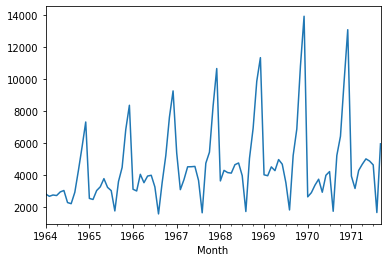

In [16]:
import pandas as pd
from matplotlib import pyplot
series = pd.read_csv('dev_champagne_sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series.plot()
pyplot.show()

**Line Plot Observations**
- There may be an increasing trend of sales over time
- There appears to be systematic seasonality to the sales for each year
- The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change)
- There does not appear to be any obvious outliers
- The seasonality suggests that the series is almost certainly non-stationary
- There may be benefit in explicitly modelling the seasonal component and removing it.
- You could also explore using differencing with one or two levels in order to make the series stationary
- The increasing trend or growth in the seasonal component may suggest the use of a log or other power transform

**Additional analysis - Seasonal Line Plots**
- We can confirm the assumption that the seasonality is a yearly cycle by eyeballing line plot of dataset by year.
- The example provides the full 7 years of data as separate groups and creates one line plot for each.
- the line plots are aligned vertically to help spot any yesar-to-year pattern

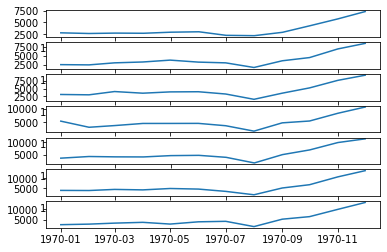

In [18]:
import pandas as pd
from matplotlib import pyplot

# load data
series = pd.read_csv('dev_champagne_sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# data preparation
groups = series['1964':'1970'].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
  pyplot.subplot((n_groups*100) + 10 + i)
  i += 1
  pyplot.plot(group)
pyplot.show()

**Seasonal Line Plot Observations**
- We can claerly see a dip each August and a rise from each August to December
- This pattern appears the same each year, although a different levels.
- This will help with any explicitly season-based modelling later
- Enhancement: It might have been easier if all season line plots were added to the one graph (in different colours) to help contrast the data for each year

**Density Plot**

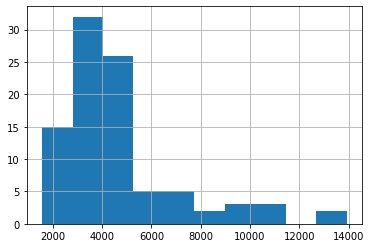

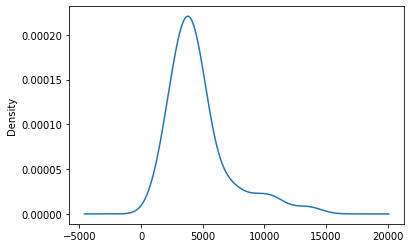

In [20]:
# Density plot
import pandas as pd
from matplotlib import pyplot

# load data
series = pd.read_csv('dev_champagne_sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# History plot
series.hist()
pyplot.show()
# Density plot
series.plot(kind='kde')
pyplot.show()


**Density Plot Observations**
- The plot is not Gaussian
- The shape has a long right tail and may suggest an exponential distribution

**Conclusion**
- This lends more support to exploring some power transforms of the data prior to modelling


**Box and Whisker Plot**
- Only 1964 to 1970 was considered
- The last year (1970) was ignored because it only contained 9 months of data.

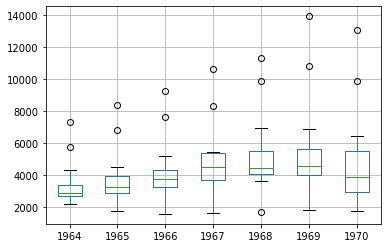

In [23]:
import pandas as pd
from matplotlib import pyplot

# load data
series = pd.read_csv('dev_champagne_sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
groups = series['1964':'1970'].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()

for name, group in groups:
  years[name.year] = group.values
years.boxplot()
pyplot.show()

**Density Plot Observations**
- The median value for each year (green line) may show an increasing trend (except 1970)
- The spread or middle 50% of the data (blue boxes) does appear reasonably stable
- There are outliers each year (black crosses); these may be the tops or bottoms of the seasonal cycle
- The last year, 1970 does look different from the trend in the prior years

**Summary**
- Observations suggest perhaps some growth trend over the years & outliers may be a part of the seasonal cycle
**Additional Analysis**
- This yearly view of the data is an interesting avenue & could be persued further by looking at summary statistics from year-to-year and changes in summary stats from year-to-year

# ARIMA Model